## Score matching 

we have data $p_{d}(x)$ and since this is diffcult to model directly, we want to fit a model $p_{m}(x, \theta)$. Here $\theta$ is the parameter of the model. As we train the model, we want to match the data distribution $p_{d}(x)$ as closely as possible.

we can write $p_{m}(x, \theta)$ as:

$$
p_m(x;\theta) = \frac{\tilde{p}(x;\theta)}{Z_\theta}, \quad Z_\theta = \int_\mathcal{X} \tilde{p}(x;\theta)dx.
$$


where $\tilde{p}$ is the unnormalized model distribution. Now since z is intractable we can remove this by derivating the above equation with respect to x 

$$
\nabla_{\mathbf{x}} \log p_m(x;\theta) = \nabla_{\mathbf{x}} \log \tilde{p}(x;\theta)  + \nabla_{\mathbf{x}} \log Z_\theta
$$

and since $z_\theta$ is independent of x, we can remove it.

$$
\nabla_{\mathbf{x}} \log p_m(x;\theta) = \nabla_{\mathbf{x}} \log \tilde{p}(x;\theta)
$$

so even though it is not the model distribution in its original form, score function gives the gradient of the model distribution. So here we will match the gradient of the model distribution with the gradient of the data distribution. Using fisher divergence we can write the difference between the two gradients as:

$$
\frac{1}{2}\mathbb{E}_{p_d}\left[\|\nabla_x \log p_d(x) - \nabla_x \log p_m(x;\theta)\|_2^2\right].
$$

and minimizing this is important to us. but computing this is difficult. The authors of the paper derived and wrote this in a simpler form as:

$$
L(\theta) \approx \frac{1}{n}\sum_{i=1}^n\left[\text{tr}\left(\nabla_x^2\log p_m(x_i;\theta)\right) + \frac{1}{2}\|\nabla_x\log p_m(x_i;\theta)\|_2^2\right]
$$

A detailed blog is on how we have arrived at this equation is [here]( https://andrewcharlesjones.github.io/journal/21-score-matching.html).

so, ultimately this means that 
- we do a forward pass of the network 
- we take the gradient of the output with respect to the input (jacobian) - this is the score function. this is the 2nd term in the equation above.
- we take another derivative of the score function with respect to the input (hessian) - this is the 1st term in the equation above. but while taking hessian we need to take care of the fact that we just need the diagonal elements of the hessian matrix. 






Now we will work on a toy example to understand this better.  Lets consider we have a 2D input and we want to fit a linear model to it with output having sigmoid.

## 1st layer 
$$
\begin{bmatrix} y_1 \\ y_2 \end{bmatrix} = \begin{bmatrix} w_{11} & w_{12} \\ w_{21} & w_{22} \end{bmatrix} \begin{bmatrix} x_1 \\ x_2 \end{bmatrix} + \begin{bmatrix} b_1 \\ b_2 \end{bmatrix}
$$

$$
 \begin{bmatrix} y_1 \\ y_2 \end{bmatrix} = \begin{bmatrix} w_{11} x_1 + w_{21} x_2 + b_1 \\ w_{12} x_1 + w_{22} x_2 + b_2 \end{bmatrix}
$$

## 2nd layer 
$$
\begin{bmatrix} y_1 \\ y_2 \end{bmatrix} = \begin{bmatrix} \sigma(y_1) \\ \sigma(y_2) \end{bmatrix}
$$


Now lets calculate the score function $s_\theta(x)$ aka jacobian of the output with respect to the input.

$$
J = \begin{bmatrix}
\frac{\partial y_1}{\partial x_1} & \frac{\partial y_1}{\partial x_2} \\
\frac{\partial y_2}{\partial x_1} & \frac{\partial y_2}{\partial x_2}
\end{bmatrix}
$$

The hessian is the derivative of the jacobian with respect to the input. 

the hessian wrt to y1 is 

$$
\frac{\partial^2 y_1}{\partial x_1^2} = \frac{\partial}{\partial x_1} \left( \frac{\partial y_1}{\partial x_1} \right)
$$

the hessian wrt to y2 is 

$$
\frac{\partial^2 y_2}{\partial x_2^2} = \frac{\partial}{\partial x_2} \left( \frac{\partial y_2}{\partial x_2} \right)
$$

Now lets calculate the gradient for each element. In the above the first element is 

$$
y1 = \sigma(w_{11} x_1 + w_{21} x_2 + b_1)
$$

as we know the derivative of sigmoid is 

$$
\sigma'(x) = \sigma(x) (1 - \sigma(x))
$$

$$
\frac{\partial y_1}{\partial x_1} = \sigma (w_{11} x_1 + w_{21} x_2 + b_1) (1 - \sigma (w_{11} x_1 + w_{21} x_2 + b_1)) w_{11}
$$

$$
\frac{\partial y_2}{\partial x_2} = \sigma (w_{12} x_1 + w_{22} x_2 + b_2) (1 - \sigma (w_{12} x_1 + w_{22} x_2 + b_2)) w_{22}
$$


Now lets take some values and calculate this . we will take w_11 = 1, w_12 = 2, w_21 = 3, w_22 = 4, b_1 = 0, b_2 = 0, x_1 = 1, x_2 = 1

$$
\frac{\partial y_1}{\partial x_1} = \sigma (1 + 3 + 0) (1 - \sigma (1 + 3 + 0)) 1 = 0.017
$$

we will see in pytorch how to calculate this. 

In [21]:
import matplotlib.pyplot as plt
plt.style.use("bmh")
%matplotlib inline


In [1]:
import torch
import torch.nn as nn

# Simple score network
class ToyScoreNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(2, 2)  # 2D input -> 2D output
        self.linear.weight.data = torch.tensor([[1, 3], [2, 4]]).float()
        self.linear.bias.data = torch.tensor([0, 0]).float()
        
    def forward(self, x):
        return torch.sigmoid(self.linear(x))  # Returns score: [∂/∂x₁ log p, ∂/∂x₂ log p]

# Create network and sample data
score_net = ToyScoreNetwork()
x = torch.tensor([[1.0, 1.0]], requires_grad=True)  # One 2D point

# Method 1: Computing full gradients
score = score_net(x)  # Shape: [1, 2]
print("Score output:", score)


Score output: tensor([[0.9820, 0.9975]], grad_fn=<SigmoidBackward0>)


In [2]:
grad1 = torch.autograd.grad(-score.sum(), x, create_graph=True)
grad1

(tensor([[-0.0226, -0.0629]], grad_fn=<MmBackward0>),)

In [3]:
torch.autograd.grad(
        score[:, 0],  # Take i-th component
        x,
        create_graph=True
    )[0]

tensor([[0.0177, 0.0530]], grad_fn=<MmBackward0>)

so if u see 0.017 term matches up with our original calculation. to calculate the overall loss we sum over the two terms and do the following

In [4]:
div = 0 
for i in range(2):  # For each dimension
    grad_i = torch.autograd.grad(
        score[:, i].sum(),  # Take i-th component
        x,
        create_graph=True
    )[0][:, i]  # Take i-th diagonal element
    div += grad_i
    print(f"Diagonal element {i}:", grad_i)
print("loss", div)

Diagonal element 0: tensor([0.0177], grad_fn=<SelectBackward0>)
Diagonal element 1: tensor([0.0099], grad_fn=<SelectBackward0>)
loss tensor([0.0275], grad_fn=<AddBackward0>)


> Note: In the above code, gradient is calculated with respect to each output score value. for a 32x32 image, we have 1024 output scores. so we will have 1024 gradients passing. This can be quite slow and time consuming. 

> So there is another paper called [sliced score matching] to solve this.

## Sliced score matching
The fisher divergence between two distribution - data distribution vs model distribution is now defined as 

$$
\frac{1}{2}\mathbb{E}_{p_v}\mathbb{E}_{p_d}\left[\| s_m(x;\theta) - s_d(x)\|_2^2\right].
$$

using sliced score matching this becomes 
$$
\mathbb{E}_{p_v} \mathbb{E}_{p_d} [\mathbf{v}^T \nabla_{\mathbf{x}} s_m(\mathbf{x}; \boldsymbol{\theta})\mathbf{v} + \frac{1}{2}(\mathbf{v}^T s_m(\mathbf{x}; \boldsymbol{\theta}))^2]
$$

Other than our requirements on pv, the assumptions are exactly the same as in Theorem 1 of Hyvärinen (2005).


Lets now see what is multivariate normal distribution means

## Multivariate normal distribution

In [39]:
import torch
import torch.distributions as distributions

# For a d-dimensional multivariate normal distribution
d = 2  # Change this to your desired dimension # using this for visualization

# Create a standard multivariate normal distribution
# Mean = zero vector, Covariance = identity matrix
mean = torch.zeros(d)
covariance = torch.eye(d)  # Identity matrix

# Create the distribution
mvn = distributions.MultivariateNormal(loc=mean, covariance_matrix=covariance)

# Sample from the distribution
samples = mvn.sample()  # Single sample
multiple_samples = mvn.sample((1000,))
multiple_samples.shape

torch.Size([1000, 2])

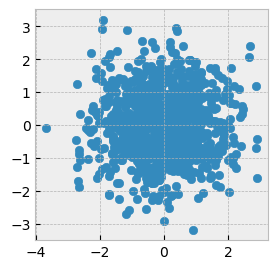

In [40]:
plt.figure(figsize=(3, 3))
plt.scatter(multiple_samples[:, 0], multiple_samples[:, 1])
plt.show()

<Figure size 400x400 with 0 Axes>

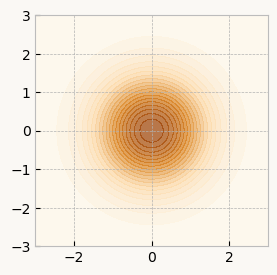

In [37]:
# Create a grid of points
import numpy as np
from matplotlib.colors import LinearSegmentedColormap
x = np.linspace(-3, 3, 100)
y = np.linspace(-3, 3, 100)
X, Y = np.meshgrid(x, y)

# Combine the grid points into coordinates
pos = np.empty(X.shape + (2,))
pos[:, :, 0] = X
pos[:, :, 1] = Y

# Calculate the PDF values at each point
Z = np.zeros(X.shape)
for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        point = torch.tensor([X[i, j], Y[i, j]], dtype=torch.float32)
        Z[i, j] = torch.exp(mvn.log_prob(point)).item()

# Create a figure with two subplots
fig = plt.figure(figsize=(4, 4))
colors = [(1, 0.98, 0.94), (0.99, 0.85, 0.65), (0.85, 0.5, 0.1), (0.6, 0.24, 0)]
cmap_name = 'cream_orange'
cm = LinearSegmentedColormap.from_list(cmap_name, colors, N=100)

plt.figure(figsize=(3, 3), facecolor='#FAF8F4')
ax = plt.axes()
ax.set_facecolor('#FAF8F4')

# Plot the density as a color map
plt.contourf(X, Y, Z, cmap=cm, alpha=0.7, levels=20)
plt.show()

## caluculate SSM

In [42]:
score_net = ToyScoreNetwork()
x = torch.tensor([[1.0, 1.0]], requires_grad=True)  # One 2D point

# Method 1: Computing full gradients
score = score_net(x)  # Shape: [1, 2]
print(score)

tensor([[0.9820, 0.9975]], grad_fn=<SigmoidBackward0>)


In [47]:
def projection(x, d=1):
    # Create a standard multivariate normal distribution
    # Mean = zero vector, Covariance = identity matrix
    mean = torch.zeros(d)
    covariance = torch.eye(d)  # Identity matrix

    # Create the distribution
    mvn = distributions.MultivariateNormal(loc=mean, covariance_matrix=covariance)
    return mvn
proj = projection(x, d=1)

In [57]:
# V.T * score => [1, 2] [2, 1] => [1, 1]
vectors = proj.sample((score.shape[1],)).T
vectors.shape, vectors

(torch.Size([1, 2]), tensor([[-1.1197, -0.3042]]))

In [58]:
v_dot_score = torch.sum(vectors * score, dim=1)
v_dot_score.shape

torch.Size([1])

In [59]:
grad_v_dot_score = torch.autograd.grad(
            v_dot_score.sum(), x, create_graph=True)[0]
grad_v_dot_score

tensor([[-0.0213, -0.0623]], grad_fn=<MmBackward0>)

In [63]:
# Finally compute v^T ∇_x s(x) v
term1 = torch.sum(vectors * grad_v_dot_score, dim=1)
term1

tensor([0.0428], grad_fn=<SumBackward1>)

In [64]:
# Term 2: (1/2) (v^T s(x))^2
term2 = 0.5 * v_dot_score**2
term2 

tensor([0.9841], grad_fn=<MulBackward0>)

In [65]:
ssm = term1 + term2
ssm


tensor([1.0269], grad_fn=<AddBackward0>)

In [68]:
term2_vr = 0.5 *torch.sum(score**2)
term2_vr
ssm_vr = term1 + term2_vr
ssm_vr


tensor([1.0225], grad_fn=<AddBackward0>)

> more or less ssm_vr and ssm are same during initialization. 

In [ ]:
## VAE with implicit encoders 